It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/mehrerm/intro_deep_learning/blob/main/class/RNN/Seq2seq.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/mehrerm/intro_deep_learning/blob/main/class/RNN/Seq2seq.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

In this example, we train a model to learn to add two numbers, provided as strings.

**Example:**

- Input: "535+61"
- Output: "596"

[Notebook from Keras Tutorial](https://keras.io/examples/nlp/addition_rnn/)

## Seq to seq model

Keras provides the `return_state` argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c). Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [2]:
(timesteps, features, output_timesteps) = (10, 5, 12)

# Encoder
encoder_input = tf.keras.Input(shape=(timesteps, features),
                               name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(64, return_state=True,
                                       name="encoder")(encoder_input)
# Enncoded vector
encoder_state = [state_h, state_c]

# Decoder
decoder_input = tf.keras.Input(shape=(output_timesteps, 1),
                               name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, return_sequences=True,
                             name="decoder")(decoder_input,
                                             initial_state=encoder_state)
output = layers.TimeDistributed(layers.Dense(5))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (LSTM)      │ [(None, 64),      │     17,920 │ encoder_input[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (LSTM)      │ (None, 12, 64)    │     16,896 │ decoder_input[0]… │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 5)     │        325 │ decoder[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,141 (137.27 KB)

 Trainable params: 35,141 (137.27 KB)

 Non-trainable params: 0 (0.00 B)

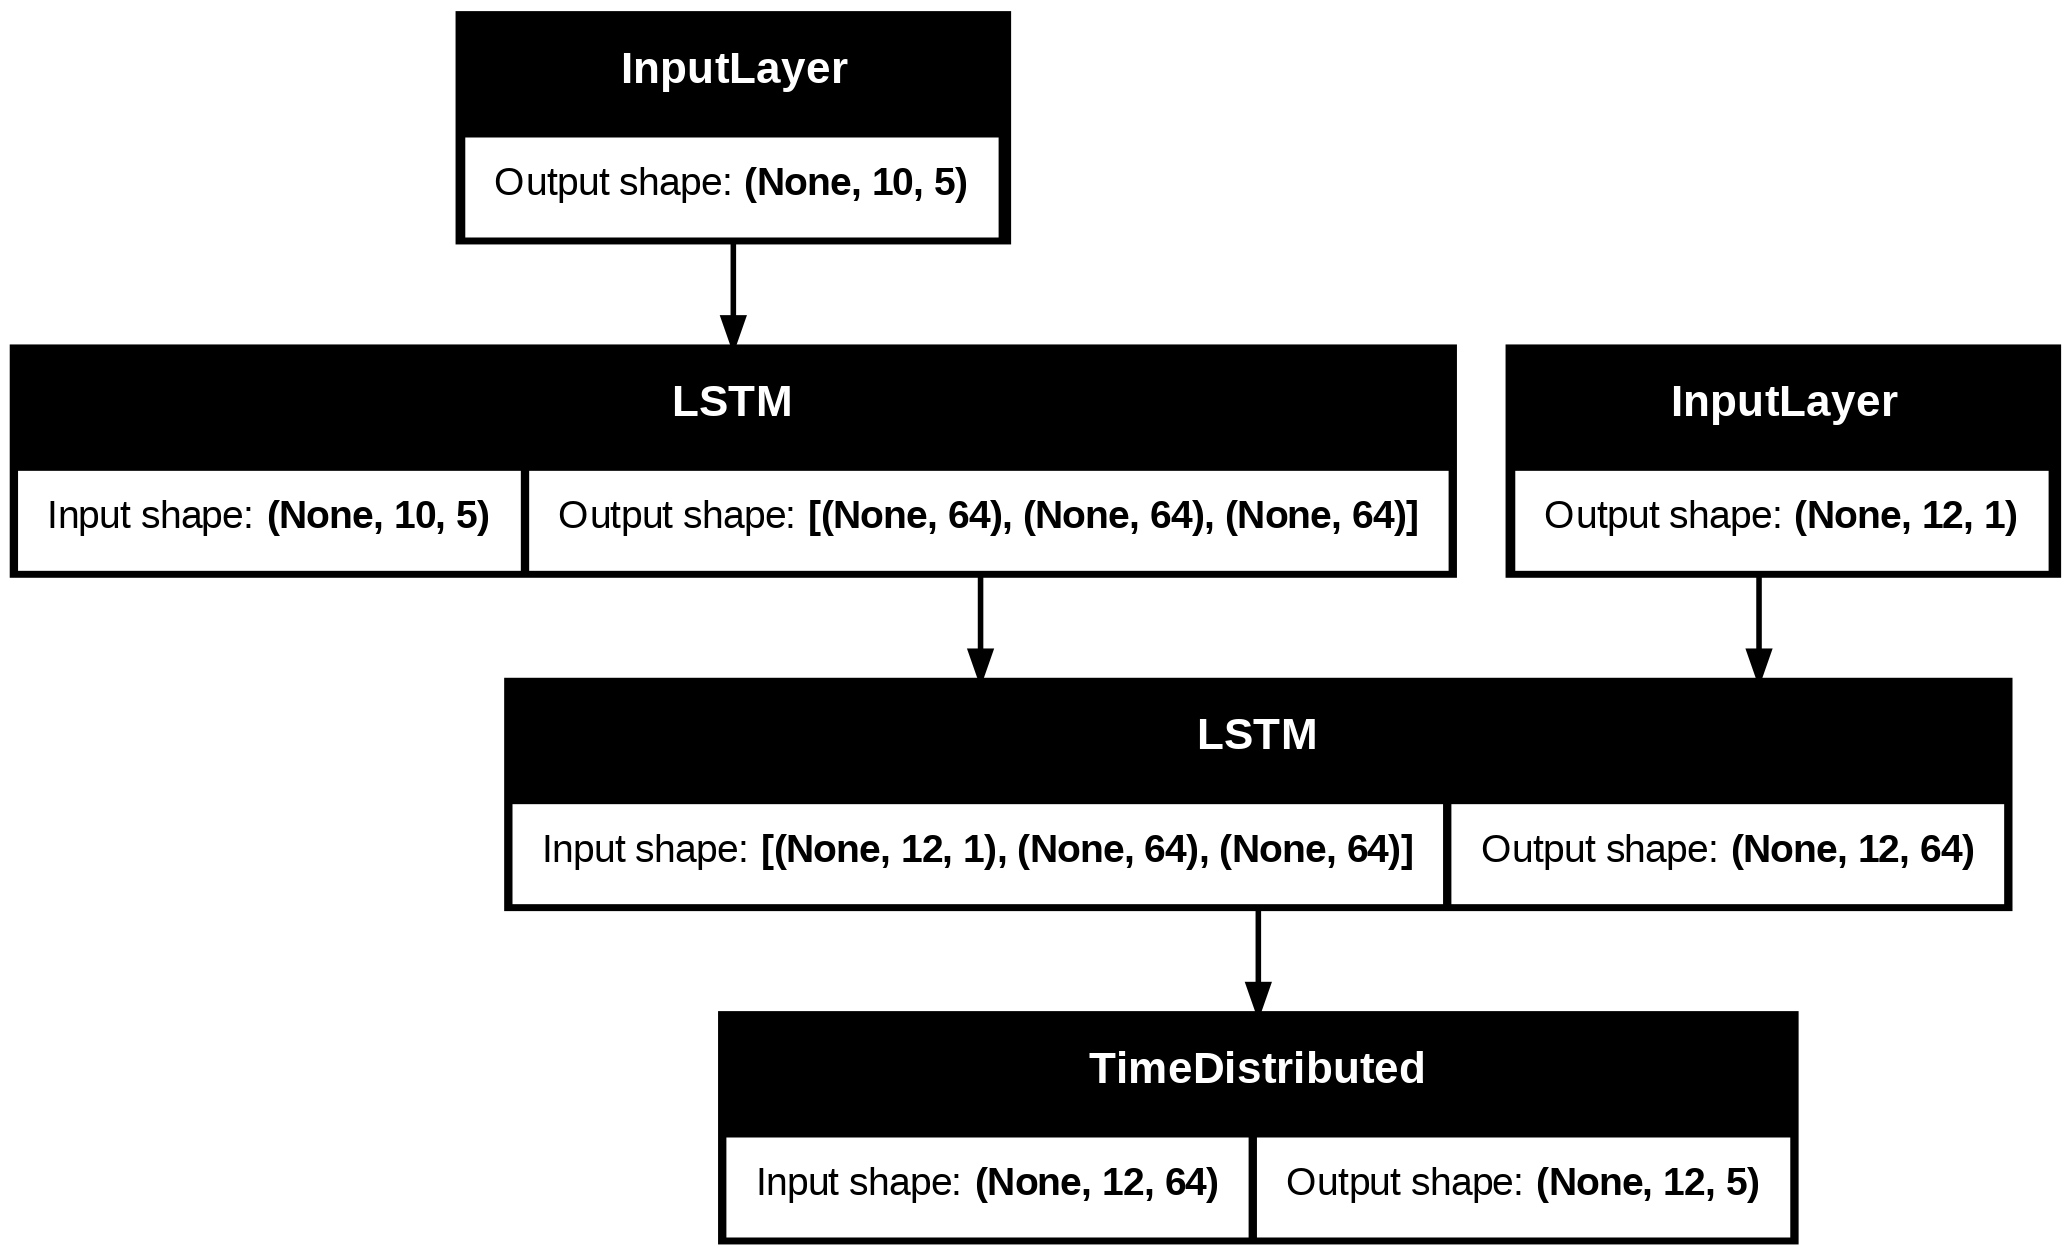

In [3]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [4]:
class Seq2seq(tf.keras.Model):
    def __init__(self, encoded_dim, out_max_len, vocab_size):
        super(Seq2seq, self).__init__()
        self.encoded_dim = encoded_dim
        self.out_max_len = out_max_len
        self.vocab_size = vocab_size
        self.lstm_encoder = tf.keras.layers.LSTM(
            self.encoded_dim, return_state=True, name='lstm_encoder')
        self.decoder_rnn_cell = tf.keras.layers.LSTMCell(
            self.encoded_dim, name='LSTM_cell')
        self.fc = tf.keras.layers.Dense(
            self.vocab_size, activation='softmax', name='output_layer')

    def call(self, inputs):
        _, state_h, state_c = self.lstm_encoder(inputs)
        # Enncoded vector
        encoder_state = [state_h, state_c]

        outputs = []
        for i in range(self.out_max_len):
            if i == 0:
                out, states = self.decoder_rnn_cell(
                    state_h, states=encoder_state)
            else:
                out, states = self.decoder_rnn_cell(out, states=states)
            outs = self.fc(out)
            outputs.append(outs)

        return outputs
# y_train <- list(y_train.swapaxes(0,1))
# vocab_size = len(chars)
# model = Seq2seq(encoded_dim, out_max_len, vocab_size)

You can also use [layers.RepeatVector](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)

In [5]:
model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
model.add(layers.LSTM(128, input_shape=(timesteps, features)))
model.add(layers.RepeatVector(output_timesteps))
model.add(layers.LSTM(128, return_sequences=True))
# Apply a dense layer to the every temporal slice of an input
model.add(layers.Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 5)          │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,837 (784.52 KB)

 Trainable params: 200,837 (784.52 KB)

 Non-trainable params: 0 (0.00 B)

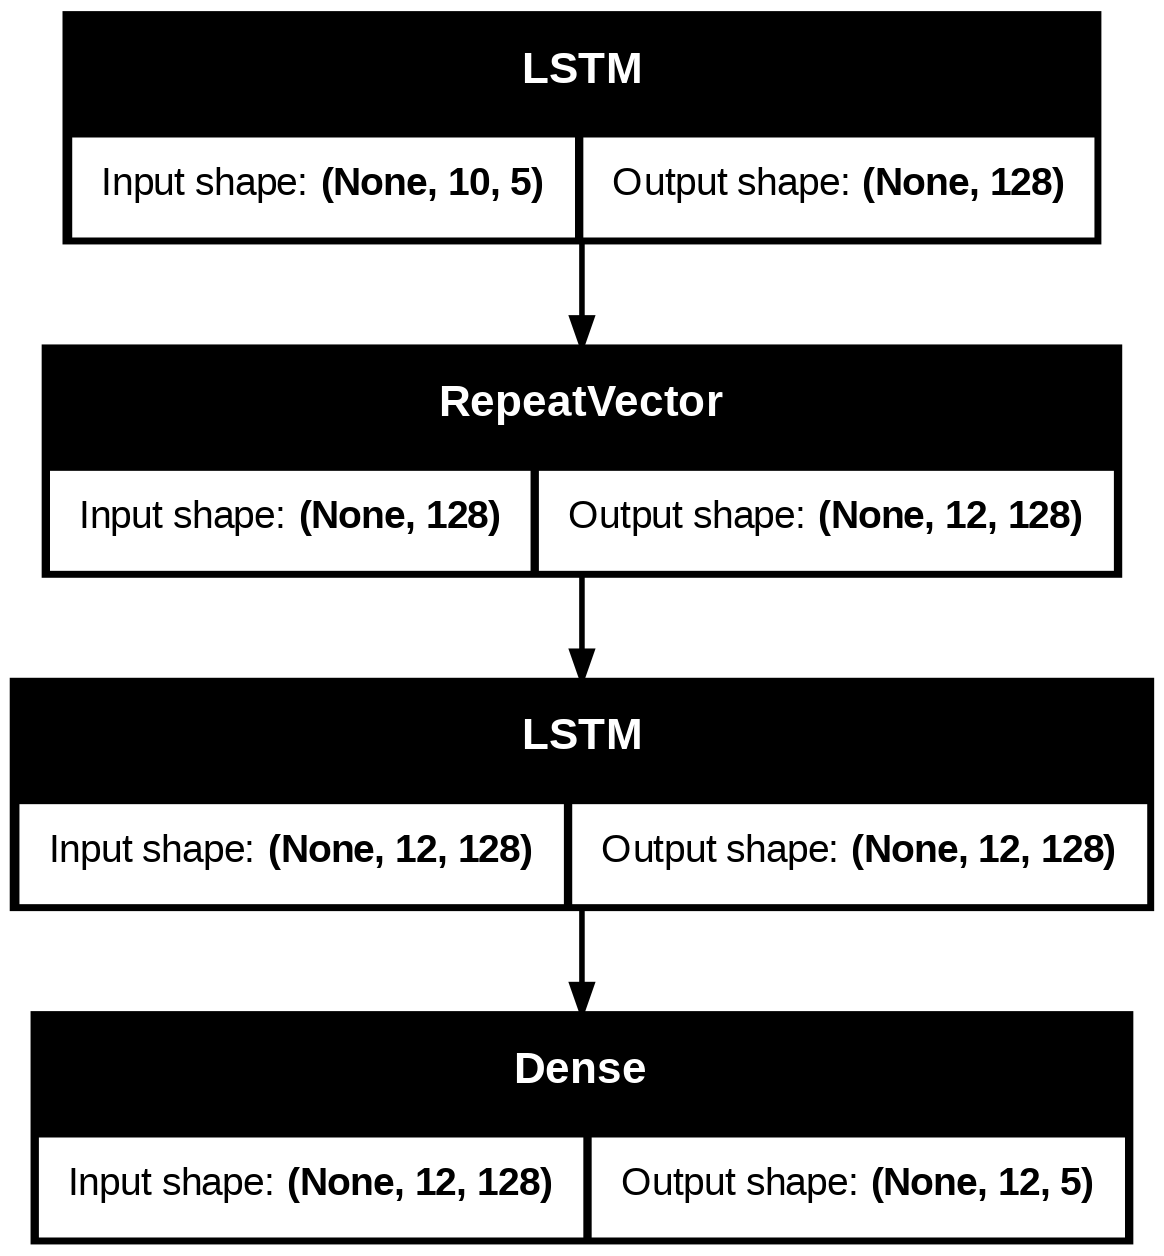

In [6]:
plot_model(model, show_shapes=True)

## Generate the data


In [7]:
max_digits = 3
max_int = 10**max_digits - 1
max_len = max_digits + 1 + max_digits
out_max_len = len(str(max_int + max_int))
print('max_digits : {0}, max_int: {1}, max_len: {2}, out_max_len: {3}'.format(
    max_digits, max_int, max_len, out_max_len))
print('max input length from {0}+{0} is {1}'.format(max_int,max_len))
print('max sum: {0}+{0}={1}'.format(max_int,max_int+max_int))

max_digits : 3, max_int: 999, max_len: 7, out_max_len: 4
max input length from 999+999 is 7
max sum: 999+999=1998


In [8]:
def generate_sample(max_len, max_int, out_max_len):
    a, b = np.random.randint(max_int, size=2)
    sentence = '{0}+{1}'.format(a, b)
    sentence = sentence + ' ' * (max_len - len(sentence))  # padding
    result = str(a + b)
    result = result + ' ' * (out_max_len - len(result))  # padding
    return sentence, result


sentences = []
results = []
seen = set()
print("Generating data...")
while len(sentences) < 50000:
    sentence, result = generate_sample(max_len, max_int, out_max_len)
    if sentence in seen:
        continue
    seen.add(sentence)
    sentences.append(sentence)
    results.append(result)
print("Total sentences:", len(sentences))
print('Some examples:', list(zip(sentences[:3], results[:3])))

Generating data...
Total sentences: 50000
Some examples: [('45+849 ', '894 '), ('102+621', '723 '), ('753+471', '1224')]


## Vectorize the data


In [10]:
chars = "0123456789+ "

char_indices = {c:i for i, c in enumerate(sorted(chars))}
print('char_indices', char_indices)
indices_char = {i:c for c,i in char_indices.items()}
print('indices_char', indices_char)

def vectorize_sentence(sentence, char_indices):
    x = np.zeros((len(sentence), len(char_indices)))
    for i, c in enumerate(list(sentence)):
        x[i, char_indices[c]] = 1
    return x

x = vectorize_sentence('13+11', char_indices)

print('sentence: 13+11')
print('vectorize_sentence inds:', x.argmax(-1))
print('vectorize_sentence :', x)

char_indices {' ': 0, '+': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
indices_char {0: ' ', 1: '+', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9'}
sentence: 13+11
vectorize_sentence inds: [3 5 1 3 3]
vectorize_sentence : [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
def vec_to_sentence(x, indices_char):
    return "".join(indices_char[i] for i in x)

def mat_to_sentence(x, indices_char):
    x = x.argmax(axis=-1)
    return "".join(indices_char[i] for i in x)

mat_to_sentence(x, indices_char)

'13+11'

In [12]:
print("Vectorization...")
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), out_max_len, len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    x[i] = vectorize_sentence(sentence, char_indices)
for i, sentence in enumerate(results):
    y[i] = vectorize_sentence(sentence, char_indices)

# Explicitly set apart 10% for validation data that we never train over.
val_split = int(0.8 * len(x))
test_split = int(0.9 * len(x))

(x_train, y_train) = x[:val_split], y[:val_split]
(x_val, y_val) = x[val_split:test_split], y[val_split:test_split]
(x_test, y_test) = x[test_split:], y[test_split:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

print("Test Data:")
print(x_test.shape)
print(y_test.shape)

Vectorization...
Training Data:
(40000, 7, 12)
(40000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Test Data:
(5000, 7, 12)
(5000, 4, 12)


## Build the model


In [13]:
encoded_dim = 16

In [14]:
# Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(encoded_dim, return_state=True, name="encoder")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]




# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(encoded_dim, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.TimeDistributed(layers.Dense(len(chars), activation='softmax'))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (LSTM)      │ [(None, 16),      │      1,856 │ encoder_input[0]… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (LSTM)      │ (None, 4, 16)     │      1,152 │ decoder_input[0]… │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 12)     │        204 │ decoder[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,212 (12.55 KB)

 Trainable params: 3,212 (12.55 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
## The inputs of the decoder are zeros
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))


In [17]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)


Iteration 1
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2600 - loss: 2.2016 - val_accuracy: 0.3111 - val_loss: 1.9233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step

Input:  613+233 Correct output 846 
Prediction
☒ 100 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Input:  240+124 Correct output 364 
Prediction
☒ 100 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Input:  607+599 Correct output 1206
Prediction
☒ 110 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Input:  800+499 Correct output 1299
Prediction
☒ 1100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Input:  375+488 Correct output 863 
Prediction
☒ 110 

Iteration 2
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3132 - loss: 1.8991 - val_accuracy: 0.3234 - val_loss: 1.8245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Input:  249+236 Correct output 485 
Prediction
☒ 100 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Input:  592+977 Correct output 1569
Prediction
☒ 1100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Input:  140+135 Correct output 275 
Prediction
☒ 

In [18]:
decoder_input_data_test = np.zeros((len(x_test), out_max_len, 1))

results = model.evaluate([x_test, decoder_input_data_test], y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5180 - loss: 1.2805
Test Loss: 1.28013277053833
Test Accuracy: 0.5217999815940857


### Question 1: Find a model with test `accuracy> 0.9`


Study the influence of the encoded vector dimension

In [30]:
##encoded_dim = ...
encoded_dim = 100

In [31]:
## Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(encoded_dim, return_state=True, name="encoder")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]


# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

decoder_output = layers.LSTM(encoded_dim, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.TimeDistributed(layers.Dense(len(chars), activation='softmax'))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (LSTM)      │ [(None, 100),     │     45,200 │ encoder_input[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (LSTM)      │ (None, 4, 100)    │     40,800 │ decoder_input[0]… │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 4, 12)     │      1,212 │ decoder[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,212 (340.67 KB)

 Trainable params: 87,212 (340.67 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
## The inputs of the decoder are zeros
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))


In [33]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)


Iteration 1
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.2986 - loss: 2.0229 - val_accuracy: 0.3640 - val_loss: 1.6804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step

Input:  627+810 Correct output 1437
Prediction
☒ 1256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Input:  834+350 Correct output 1184
Prediction
☒ 105 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Input:  726+625 Correct output 1351
Prediction
☒ 1055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Input:  226+546 Correct output 772 
Prediction
☒ 695 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Input:  115+289 Correct output 404 
Prediction
☒ 455 

Iteration 2
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4068 - loss: 1.5924 - val_accuracy: 0.4561 - val_loss: 1.4690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Input:  927+590 Correct output 1517
Prediction
☒ 1545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Input:  529+497 Correct output 1026
Prediction
☑ 1026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Input:  772+481 Correct output 1253
Predictio

In [34]:
decoder_input_data_test = np.zeros((len(x_test), out_max_len, 1))
results = model.evaluate([x_test, decoder_input_data_test], y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9680 - loss: 0.1001
Test Loss: 0.10130342096090317
Test Accuracy: 0.9678000211715698


## Practice

Create a similar model for integer division, rounded to 3 decimals:
```python
'999/7' -> '142.714'
'3/4' -> '0.75'
'1/3' -> '0.333'
```

In [ ]:
max_digits = 3
max_int = 10**max_digits - 1
max_len = ...#
out_max_len = ...#
print('max_digits : {0}, max_int: {1}, max_len: {2}, out_max_len: {3}'.format(
    max_digits, max_int, max_len, out_max_len))

In [ ]:
np.random.randint(max_int)

In [ ]:
def generate_sample(max_len, max_int, out_max_len):
    a = np.random.randint(...)
    b = np.random.randint(...) # zero division
    sentence = ...
    sentence = sentence + ' ' * (max_len - len(sentence))  # padding
    result = str(np.round(a / b, 3))
    result = result + ' ' * (out_max_len - len(result))  # padding
    return sentence, result

sentences = []
results = []
seen = set()
print("Generating data...")
while len(sentences) < ...:
    sentence, result = generate_sample(max_len, max_int, out_max_len)
    if sentence in seen:
        continue
    seen.add(sentence)
    sentences.append(sentence)
    results.append(result)
print("Total sentences:", len(sentences))
print('Some examples:', list(zip(sentences[:3], results[:3])))

In [ ]:
## Data vectorization

chars = ...

char_indices = {c:i for i, c in enumerate(sorted(chars))}
print('char_indices', char_indices)
indices_char = {i:c for c,i in char_indices.items()}
print('indices_char', indices_char)

def vectorize_sentence(sentence, char_indices):
    x = np.zeros((len(sentence), len(char_indices)))
    for i, c in enumerate(list(sentence)):
        x[i, char_indices[c]] = 1
    return x

x = vectorize_sentence('13/11', char_indices)

print('sentence: 13/11')
print('vectorize_sentence inds:', x.argmax(-1))
print('vectorize_sentence :', x)

In [ ]:
def vec_to_sentence(x, indices_char):
    return "".join(indices_char[i] for i in x)

def mat_to_sentence(x, indices_char):
    x = x.argmax(axis=-1)
    return "".join(indices_char[i] for i in x)

mat_to_sentence(x, indices_char)

In [ ]:
print("Vectorization...")
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), out_max_len, len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    x[i] = vectorize_sentence(sentence, char_indices)
for i, sentence in enumerate(results):
    y[i] = vectorize_sentence(sentence, char_indices)

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

In [ ]:
# Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

...

# Enncoded vector
encoder_state = ...

# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = ...

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))

In [ ]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)